In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
from multiprocessing import Process

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params, update_sev_prevalence
from analysis_helpers import poisson_waiting_function

from multi_group_simulation import MultiGroupSimulation

# Parameter Uncertainties

In [2]:
param_uncertainty = {
    'asymp_prob_mult': (15/47, 70/47), # Our nominal estimate for US population: 47%
    'inital_prev_mult': (0.5, 2),
    'R0': (2,4),
    'outside_inf_mult': (0.5, 2),
    'daily_self_report_prob': (0.2, 0.5),
    'ct_mult': (1,2),
    'ct_testing_ratio': (0.5, 1.5),
    'test_sensitivity': (0.5, 0.8),
    'test_noncompliance': (0.05, 0.2),
    'E_time': (1,3),
    'ID_time': (2,4),
    'Sy_time': (11,13),
    'virtual_noncompliance': (0.25, 0.75),
    'intermittent_non-compliance_mult': (2,4),
    'virtual_r0_mult': (0.9, 1.5),
    'virtual_pop_size': (0,1), # Slider from min to max
}

uncertainty_params_list = ['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult', 'daily_self_report_prob',
                           'ct_mult', 'ct_testing_ratio', 'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
                          'Sy_time', 'virtual_noncompliance', 'intermittent_non-compliance_mult', 'virtual_r0_mult',
                           'virtual_pop_size']

lb = list()
ub = list()

for param in uncertainty_params_list:
    lb.append(param_uncertainty[param][0])
    ub.append(param_uncertainty[param][1])

## Loading Results

In [3]:
def get_stats(inf_matrix):
    cornell_inf = np.array(inf_matrix)[:,:-1].sum(axis=1)
    ithaca_inf = np.array(inf_matrix)[:,-1]
    return np.quantile(cornell_inf, [0.1,0.5,0.9]), np.quantile(ithaca_inf, [0.1,0.5,0.9])

In [4]:
file = open('apr_19_scenarios/point_0.dill', 'rb')
[uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix] = dill.load(file)
file.close()

In [5]:
get_stats(res_inf_matrix)

(array([112.5, 145. , 183.9]), array([107.9, 130. , 144.1]))

In [6]:
scenario_data = pd.DataFrame(columns=uncertainty_params_list+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90']+
                            ['vir_cornell_inf_10','vir_cornell_inf_50','vir_cornell_inf_90','vir_ithaca_inf_10','vir_ithaca_inf_50','vir_ithaca_inf_90'])

for i in range(200):
    file = open('apr_19_scenarios/point_'+str(i)+'.dill', 'rb')
    [uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix] = dill.load(file)
    file.close()

    new_row = dict()
    for index, col_name in enumerate(uncertainty_params_list):
        new_row[col_name] = uncertainty_point[index]

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

    vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
    new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
    new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
    new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
    new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
    new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
    new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
#     print(new_row)

    scenario_data = scenario_data.append(new_row, ignore_index=True)

In [7]:
scenario_data

,asymp_prob_mult,inital_prev_mult,R0,outside_inf_mult,daily_self_report_prob,ct_mult,ct_testing_ratio,test_sensitivity,test_noncompliance,E_time,...,res_cornell_inf_90,res_ithaca_inf_10,res_ithaca_inf_50,res_ithaca_inf_90,vir_cornell_inf_10,vir_cornell_inf_50,vir_cornell_inf_90,vir_ithaca_inf_10,vir_ithaca_inf_50,vir_ithaca_inf_90
0,0.358050,0.802577,3.149947,0.554726,0.283351,1.974107,0.781738,0.747386,0.079065,1.965612,...,183.9,107.9,130.0,144.1,96.0,139.0,256.1,103.9,119.0,135.4
1,1.078162,0.646004,3.522748,1.298116,0.404513,1.235803,0.883811,0.627558,0.196968,2.340111,...,2719.1,370.7,457.0,553.0,6745.6,6880.5,7032.4,2972.9,3126.0,3361.5
2,0.473327,1.680446,3.611093,1.956306,0.349759,1.814202,0.815036,0.563230,0.116568,1.877289,...,910.1,363.6,394.0,442.4,332.2,611.0,870.7,227.5,271.5,315.2
3,1.412546,1.734111,3.848519,1.552204,0.390934,1.838125,1.231949,0.697417,0.183443,2.531080,...,814.2,402.9,455.0,508.2,7257.5,7419.0,7540.4,2938.5,3054.5,3197.9
4,0.492220,1.870288,3.071618,0.937058,0.422556,1.246799,1.047118,0.735579,0.157933,2.386976,...,302.1,230.0,252.5,279.1,223.2,322.5,444.2,224.0,251.5,296.1
5,1.192265,1.753152,2.335384,0.901259,0.251083,1.578241,0.821336,0.681542,0.147206,2.598724,...,513.3,249.7,276.5,308.2,2344.2,3061.0,3610.0,643.4,801.5,926.2
6,0.681271,1.661827,3.298222,1.949464,0.386833,1.706170,0.512948,0.607203,0.165139,1.336893,...,1192.1,392.0,428.5,466.9,1399.5,1943.0,2292.7,429.4,550.5,613.0
7,1.294868,0.628450,2.213813,0.993169,0.303864,1.221032,1.295703,0.721204,0.165825,2.798725,...,164.1,159.5,175.5,199.2,909.5,2203.0,3303.1,236.9,432.5,668.1
8,1.487471,0.893005,3.989191,0.748708,0.495740,1.288378,1.206325,0.614064,0.103908,2.633891,...,2239.5,338.0,406.0,569.1,8117.7,8267.0,8419.5,5923.8,6086.5,6406.2
9,1.362297,1.196127,2.038238,0.613993,0.345635,1.092131,1.431131,0.676915,0.117598,2.047617,...,288.1,168.8,192.5,220.0,2756.0,3233.5,3536.2,651.2,793.5,894.4


# Run the linear regression

In [8]:
from sklearn.linear_model import LinearRegression
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [12]:
scenario_data.columns

Index(['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult',
       'daily_self_report_prob', 'ct_mult', 'ct_testing_ratio',
       'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
       'Sy_time', 'virtual_noncompliance', 'intermittent_non-compliance_mult',
       'virtual_r0_mult', 'virtual_pop_size', 'res_cornell_inf_10',
       'res_cornell_inf_50', 'res_cornell_inf_90', 'res_ithaca_inf_10',
       'res_ithaca_inf_50', 'res_ithaca_inf_90', 'vir_cornell_inf_10',
       'vir_cornell_inf_50', 'vir_cornell_inf_90', 'vir_ithaca_inf_10',
       'vir_ithaca_inf_50', 'vir_ithaca_inf_90'],
      dtype='object')

In [28]:
residential_columns = scenario_data.columns[0:12]
residential_target = 'res_ithaca_inf_50'
X_res = np.matrix(scenario_data[residential_columns])
Y_res_outcomes = np.array(scenario_data[[residential_target]])

res_reg = LinearRegression().fit(X_res, Y_res_outcomes)

print("Intercept: {:.2f}".format(res_reg.intercept_[0]))
for col, coef in zip(residential_columns, res_reg.coef_[0]):
    print("{}: {:.2f}".format(col, coef))



Intercept: -216.83
asymp_prob_mult: 211.02
inital_prev_mult: 43.69
R0: 144.12
outside_inf_mult: 138.91
daily_self_report_prob: -264.75
ct_mult: -181.54
ct_testing_ratio: -113.43
test_sensitivity: -274.93
test_noncompliance: 223.65
E_time: 6.96
ID_time: 6.53
Sy_time: 24.24


In [29]:
virtual_columns = scenario_data.columns[0:16]
virtual_infs = 'vir_ithaca_inf_50'
X_vir = np.matrix(scenario_data[virtual_columns])
Y_vir_outcomes = np.array(scenario_data[[virtual_infs]])

Y_vir_target = Y_res_outcomes - Y_vir_outcomes

vir_reg = LinearRegression().fit(X_vir, Y_vir_target)
print("Intercept: {:.2f}".format(vir_reg.intercept_[0]))
for col, coef in zip(virtual_columns, vir_reg.coef_[0]):
    print("{}: {:.2f}".format(col, coef))


Intercept: 4871.04
asymp_prob_mult: -2046.78
inital_prev_mult: 248.05
R0: -1052.53
outside_inf_mult: 91.17
daily_self_report_prob: 567.95
ct_mult: 657.12
ct_testing_ratio: 307.66
test_sensitivity: 876.27
test_noncompliance: -1338.29
E_time: 40.36
ID_time: -135.85
Sy_time: -100.26
virtual_noncompliance: -2300.38
intermittent_non-compliance_mult: -58.70
virtual_r0_mult: 45.98
virtual_pop_size: -78.88


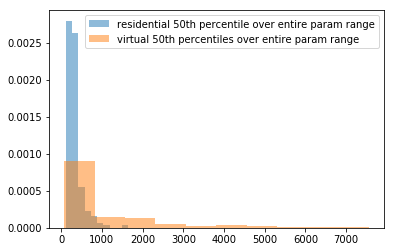

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Y_res_outcomes, label='residential 50th percentile over entire param range', alpha=0.5, normed=True)
plt.hist(Y_vir_outcomes, label='virtual 50th percentiles over entire param range', alpha=0.5, normed=True)
plt.legend(loc='best')
plt.show()

(array([86., 81., 17.,  7.,  5.,  2.,  1.,  0.,  0.,  1.]),
 array([ 116.5 ,  270.05,  423.6 ,  577.15,  730.7 ,  884.25, 1037.8 ,
        1191.35, 1344.9 , 1498.45, 1652.  ]),
 <a list of 10 Patch objects>)

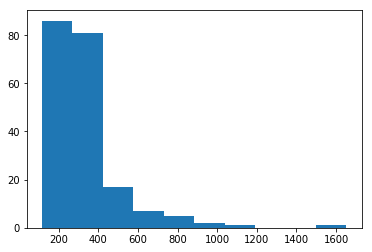

In [31]:
plt.hist(Y_res_outcomes, label='residential 50th percentile over entire param range')
